# Testing InceptionV3 network (variation 21) Fine-tuning w/ Dropout

Based on variant 15

In [1]:
import os
import time
import pickle

import numpy as np

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras import metrics

from cars_utils import time_save_model, plot_metrics, pickle_variable_to_path

Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Image, directory, and batch setup

In [2]:
# Image dimensions:
IMG_WIDTH, IMG_HEIGHT = 299, 299

WORKING_DIR = os.getcwd()
BASE = os.path.join(WORKING_DIR, 'data', 'cars_dataset', 'keras')
SAVE_DIR = os.path.join(WORKING_DIR, 'data', 'InceptionV3')

### Settings for full training
TRAIN_DATA_DIR = os.path.join(BASE, 'train')
VALIDATION_DATA_DIR = os.path.join(BASE, 'validation')
NB_CLASSES = 196
NB_TRAIN_SAMPLES = 11329
NB_VALIDATION_SAMPLES = 2428
BATCH_SIZE = 32

if K.image_data_format() == 'channels_first':
    INPUT_SHAPE = (3, IMG_WIDTH, IMG_HEIGHT)
else:
    INPUT_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

## Image augmentation generators

In [3]:
train_datagen = ImageDataGenerator(rescale=1/255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1/255)

In [4]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_DATA_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=7)

validation_generator = test_datagen.flow_from_directory(
    VALIDATION_DATA_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=13)

Found 11329 images belonging to 196 classes.
Found 2428 images belonging to 196 classes.


Save lookup_dict for predictions later on

In [6]:
lookup_dict = {value: key for key, value in train_generator.class_indices.items()}
pickle_variable_to_path(lookup_dict, 'I_15_lookup_dict', SAVE_DIR)

## Model definition

In [7]:
from keras.applications import InceptionV3

conv_base = InceptionV3(
    weights='imagenet',
    include_top=False,
    pooling='avg',
    input_shape=INPUT_SHAPE
)

In [8]:
pred_layer_config = {
    'activation': 'softmax',
    'activity_regularizer': None,
    'bias_constraint': None,
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'bias_regularizer': None,
    'kernel_constraint': None,
    'kernel_initializer': {'class_name': 'VarianceScaling',
                           'config': {
                               'distribution': 'uniform',
                               'mode': 'fan_avg',
                               'scale': 1.0,
                               'seed': 8}
                          },
    'kernel_regularizer': None,
    'name': 'predictions',
    'trainable': True,
    'units': NB_CLASSES,
    'use_bias': True}

model = Sequential()
model.add(conv_base)
model.add(Dropout(0.5, seed=21))
model.add(Dense(**pred_layer_config))

In [9]:
conv_base.trainable = True
# for layer in conv_base.layers:
#     layer.trainable = True
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

conv_base.trainable = False
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 190
This is the number of trainable weights before freezing the conv base: 2


In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 2048)              21802784  
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
predictions (Dense)          (None, 196)               401604    
Total params: 22,204,388
Trainable params: 401,604
Non-trainable params: 21,802,784
_________________________________________________________________


## Compile model

In [11]:
# custom metrics to look at
def top_3_acc(y_true, y_pred):
    return metrics.top_k_categorical_accuracy(y_true, y_pred, k=3)

def top_5_acc(y_true, y_pred):
    return metrics.top_k_categorical_accuracy(y_true, y_pred, k=5)

In [12]:
from keras import optimizers

optimizer = optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, schedule_decay=0.004)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=[metrics.categorical_accuracy, top_3_acc, top_5_acc])

## Train model!

In [ ]:
EPOCHS = 10
start_time = time.time()
summary = model.fit_generator(
    train_generator,
    steps_per_epoch=NB_TRAIN_SAMPLES // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=NB_VALIDATION_SAMPLES // BATCH_SIZE)
end_time = time.time()

Epoch 1/10
172/354 [=============>................] - ETA: 2:18 - loss: 5.5137 - categorical_accuracy: 0.0207 - top_3_acc: 0.0494 - top_5_acc: 0.0741

In [12]:
time_save_model(model,
                summary.history,
                start_time, end_time,
                'InceptionV3_21_0_10',
                SAVE_DIR)

traing took: 50.0 minutes


### Make sure that the weights saved above can actually be applied to a fresh version of the model in (Inceptionv3_21_weight_test)[Inceptionv3_21_weight_test.ipynb]

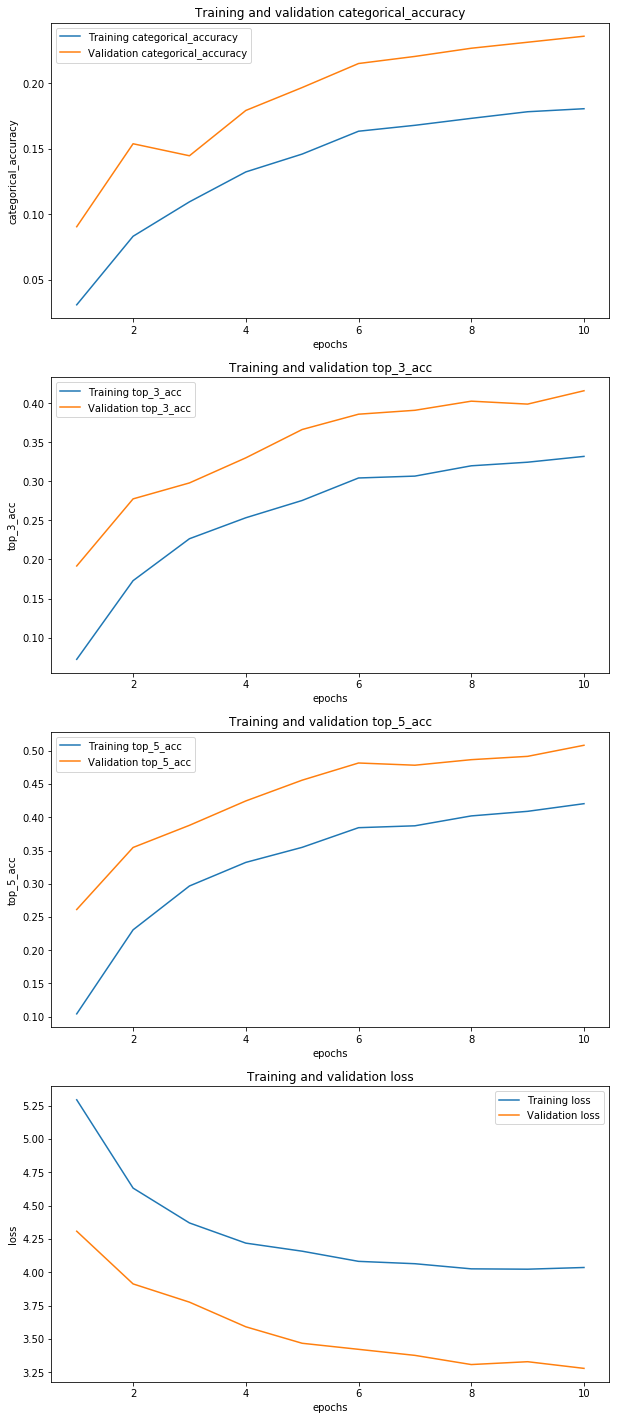

In [14]:
key_list = ['categorical_accuracy',
            'top_3_acc',
            'top_5_acc',
            'loss']
show = plot_metrics(summary.history, key_list)

## Unfreeze last layer for fine-tuning

In [15]:
### load weights from training above if instance or kernel was interrupted
# WEIGHT_PATH = os.path.join(SAVE_DIR, 'InceptionV3_13_10_20.h5')
# model.load_weights(WEIGHT_PATH)

conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name in [
        'conv2d_86', 'batch_normalization_86',
        'conv2d_87', 'batch_normalization_86',
        'conv2d_88', 'batch_normalization_88',
        'conv2d_89', 'batch_normalization_89',
        'conv2d_90', 'batch_normalization_90',
        'conv2d_91', 'batch_normalization_90',
        'conv2d_92', 'batch_normalization_92',
        'conv2d_93', 'batch_normalization_93',
        'conv2d_94', 'batch_normalization_94'
    ]:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

print('This is the number of trainable weights after '
      'after limited freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after after limited freezing the conv base: 14


In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 2048)              21802784  
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
predictions (Dense)          (None, 196)               401604    
Total params: 22,204,388
Trainable params: 3,221,700
Non-trainable params: 18,982,688
_________________________________________________________________


## Recompile
(Especially if changing learning rate)

In [17]:
optimizer = optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, schedule_decay=0.004)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=[metrics.categorical_accuracy, top_3_acc, top_5_acc])

## Train to fine-tune!

In [23]:
EPOCHS = 10
start_time = time.time()
summary = model.fit_generator(
    train_generator,
    steps_per_epoch=NB_TRAIN_SAMPLES // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=NB_VALIDATION_SAMPLES // BATCH_SIZE)
end_time = time.time()

Epoch 1/10
354/354 [==============================] - 291s 823ms/step - loss: 1.9709 - categorical_accuracy: 0.4914 - top_3_acc: 0.6994 - top_5_acc: 0.7821 - val_loss: 1.8567 - val_categorical_accuracy: 0.5154 - val_top_3_acc: 0.7312 - val_top_5_acc: 0.8025
Epoch 2/10
354/354 [==============================] - 290s 818ms/step - loss: 1.9111 - categorical_accuracy: 0.5002 - top_3_acc: 0.7135 - top_5_acc: 0.7956 - val_loss: 1.8906 - val_categorical_accuracy: 0.4979 - val_top_3_acc: 0.7204 - val_top_5_acc: 0.8013
Epoch 3/10
354/354 [==============================] - 289s 816ms/step - loss: 1.8707 - categorical_accuracy: 0.5140 - top_3_acc: 0.7260 - top_5_acc: 0.8036 - val_loss: 1.8809 - val_categorical_accuracy: 0.4929 - val_top_3_acc: 0.7267 - val_top_5_acc: 0.8021
Epoch 4/10
354/354 [==============================] - 292s 825ms/step - loss: 1.8224 - categorical_accuracy: 0.5133 - top_3_acc: 0.7360 - top_5_acc: 0.8115 - val_loss: 1.8821 - val_categorical_accuracy: 0.5000 - val_top_3_acc:

In [24]:
time_save_model(model,
                summary.history,
                start_time, end_time,
                'InceptionV3_15_FT_10_20',
                SAVE_DIR)

traing took: 48.0 minutes


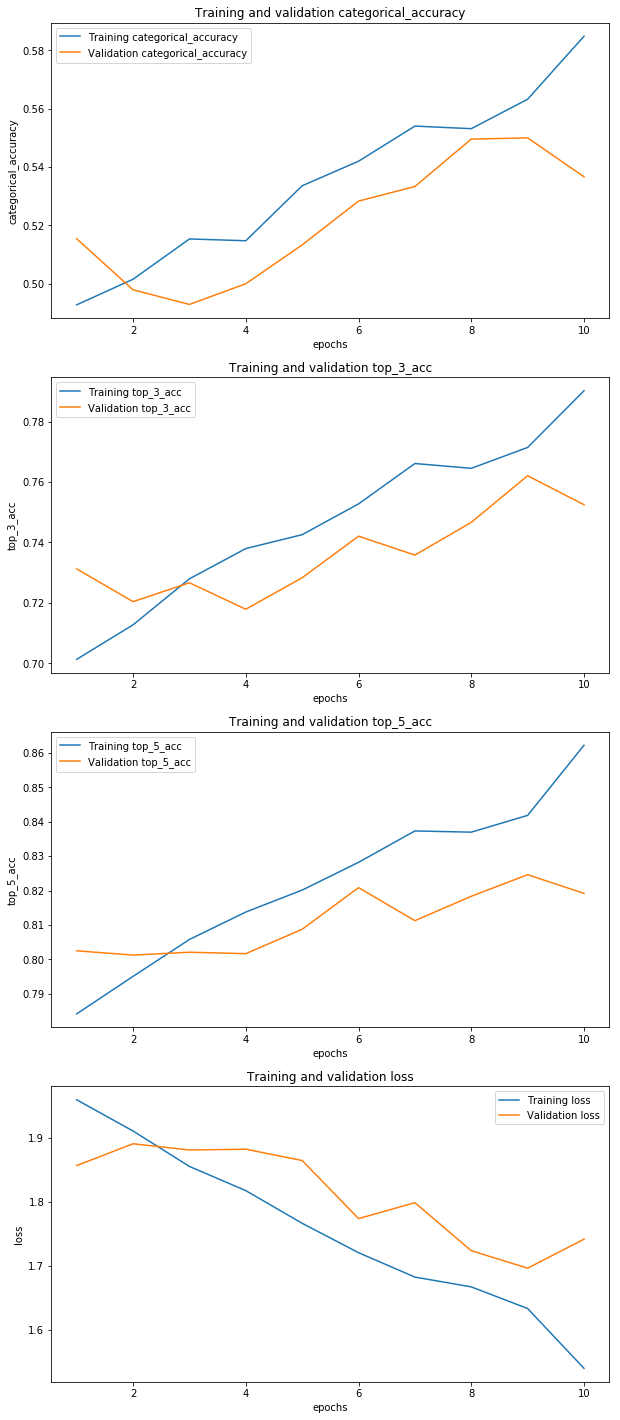

In [25]:
key_list = ['categorical_accuracy',
            'top_3_acc',
            'top_5_acc',
            'loss']
show = plot_metrics(summary.history, key_list)